# Post Calibration
1. Assess Results
    - Recalculate results for training set using best coefficients
    - Use best coefficients to calculate objective function for the test set
    - Compare against the shortest path results (with and without the elevation correction) using both training and testing sets
1. Look at where calibrated function did the best/worst job for both the training/testing set
1. Cluster/segment results based on loss function value?
4. Export for application in BikewaySim

In [1]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
import stochastic_optimization
from tqdm import tqdm
import similaritymeasures
import random
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

from shapely.ops import LineString, MultiLineString

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

from network.src import modeling_turns
import speedfactor

In [2]:
# import json
# config = json.load((Path.cwd().parent / 'config.json').open('rb'))
# calibration_fp = Path(config['project_directory']) / 'Calibration'
# cycleatl_fp = Path(config['project_directory']) / 'CycleAtlanta'
# matching_fp = Path(config['project_directory']) / 'Map_Matching'
# network_fp = Path(config['project_directory']) / 'Network'
# if calibration_fp.exists() == False:
#     calibration_fp.mkdir()

# Import Calibration Results and Calibration Network

In [3]:
#todo turn this into a function instead
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)

links['multi use path'] = links['facility_fwd'].isin(['multi use path','cycletrack']).astype(int)
links.loc[links['multi use path']==True,'lanes'] = 0

links['bike lane'] = links['facility_fwd'].isin(['bike lane','bufferred bike lane']).astype(int)
#links.loc[links['bike lane']==True,'']

In [61]:
#create layer of unsignalized crossings
unsig_major_road_crossing = set(turns.loc[turns['unsig_major_road_crossing']==True,'source_B'].tolist())
nodes = gpd.read_file(config['network_fp']/'final_network.gpkg',layer='nodes')
nodes = nodes[nodes['N'].isin(unsig_major_road_crossing)]
nodes.to_file(config['calibration_fp']/'unsig_major_road_crossing.gpkg')

## Network Statistics

In [34]:
print(links.shape[0],'links and',len(set(links['A'].append(links['B']).tolist())),'nodes')
print(turns.shape[0],'turns and',turn_G.number_of_nodes(),'intersections')

144458 links and 66151 nodes
222764 turns and 146744 intersections


In [6]:
#dicts for referencing certain link attributes quickly (should move this into a function)
length_dict = dict(zip(links['linkid'],links['length_ft'])) # need this for loss function
geo_dict = dict(zip(links['linkid'],links['geometry']))

In [7]:
# with (config['calibration_fp']/'test_set.pkl').open('rb') as fh:
#     test_set = pickle.load(fh)
# with (config['calibration_fp']/'train_set.pkl').open('rb') as fh:
#     train_set = pickle.load(fh)
with (config['calibration_fp']/'full_set.pkl').open('rb') as fh:
    full_set = pickle.load(fh)

In [8]:
#update
with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
    match_results = pickle.load(fh)

# test_set = {key:match_results.get(key,False) for key, item in test_set.items()}
# train_set = {key:match_results.get(key,False) for key, item in train_set.items()}
# test_set = {key:item for key, item in test_set.items() if item != False}
# train_set = {key:item for key, item in train_set.items() if item != False}
full_set = {key:match_results.get(key,False) for key, item in full_set.items()}
full_set = {key:item for key, item in full_set.items() if item != False}
del match_results

In [9]:
#match the ods to the network
# train_ods = stochastic_optimization.match_results_to_ods(train_set)
# test_ods = stochastic_optimization.match_results_to_ods(test_set)
full_ods = stochastic_optimization.match_results_to_ods(full_set)

# Shortest Path Comparison
Not super neccessary becuase we already have these results

In [10]:
loss_function = stochastic_optimization.jaccard_index
loss_function_kwargs = {'length_dict':length_dict}
base_impedance_col = "travel_time_min"

In [11]:
# #shortest path results here for comparison
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in train_ods}
# loss_shortest_train = loss_function(train_set,results_dict,**loss_function_kwargs)
# print(loss_shortest_train[:,1].mean().round(5))
# # 0.29911

In [12]:
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in test_ods}
# loss_shortest_test = loss_function(test_set,results_dict,**loss_function_kwargs)
# print(loss_shortest_test[:,1].mean().round(5))
# # 0.3053

In [13]:
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in full_ods}
loss_shortest_full = loss_function(full_set,results_dict,**loss_function_kwargs)
print(loss_shortest_full[:,1].mean().round(5))

0.30156


# Generate Shortest Paths from Calibrated Coefficients

In [14]:
calibration_result = calibration_results[-1]
calibration_result

{'multi use path': -0.14827102335300216,
 'bike lane': -0.44874582723328715,
 'lanes': 0.9773461720577385,
 'above_4': 2.683598621716529,
 'unsig_major_road_crossing': 7.6504858673043,
 'loss': -0.3081016034970768,
 'beta_links': {0: 'multi use path', 1: 'bike lane', 2: 'lanes', 3: 'above_4'},
 'beta_turns': {4: 'unsig_major_road_crossing'}}

In [36]:
betas = list(calibration_result.values())[0:-3]
betas_links = calibration_result['beta_links']
betas_turns = calibration_result['beta_turns']
betas

[-0.14827102335300216,
 -0.44874582723328715,
 0.9773461720577385,
 2.683598621716529,
 7.6504858673043]

In [37]:
#BUG the calibration process is not retrieving the correct coefficients anymore
betas = [-0.184,-0.398,0.126,0.325,0.324]

In [16]:
links.columns

Index(['A', 'B', 'linkid', 'reverse_link', 'link_type', 'osmid', 'highway',
       'oneway', 'name', 'year', 'AADT', 'truck_pct', 'speed', 'length_ft',
       'lanes', 'link_type_new', 'motorized', 'facility_fwd', 'improvement',
       'ascent_ft', 'ascent_grade_%', 'above_4', 'mixed_traffic_no_facil',
       'mixed_traffic_w_facil', 'travel_time_min', 'test_column', 'length_mi',
       'geometry', 'multi use path', 'bike lane', 'link_cost'],
      dtype='object')

In [39]:
#link_impedance_col = "adj_travel_time_min"
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          stochastic_optimization.link_impedance_function,
                          base_impedance_col,
                          stochastic_optimization.turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
full_results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in full_ods}

#calulate objective function
loss_full = loss_function(full_set,full_results_dict,**loss_function_kwargs)
loss_full[:,1].mean()

[-0.184, -0.398, 0.126, 0.325, 0.324]


0.3140628670934314

## Calculate the percent change in impedance at the link level for visulization

In [18]:
links.columns

Index(['A', 'B', 'linkid', 'reverse_link', 'link_type', 'osmid', 'highway',
       'oneway', 'name', 'year', 'AADT', 'truck_pct', 'speed', 'length_ft',
       'lanes', 'link_type_new', 'motorized', 'facility_fwd', 'improvement',
       'ascent_ft', 'ascent_grade_%', 'above_4', 'mixed_traffic_no_facil',
       'mixed_traffic_w_facil', 'travel_time_min', 'test_column', 'length_mi',
       'geometry', 'multi use path', 'bike lane', 'link_cost'],
      dtype='object')

In [40]:
impedance_change = links.copy()
impedance_change['imp_prop'] = (impedance_change['link_cost'] - impedance_change['travel_time_min']) / impedance_change['travel_time_min']
impedance_change['imp_prop'] = impedance_change['imp_prop'].round(3)
impedance_change = impedance_change[impedance_change['reverse_link']==False]

<AxesSubplot: >

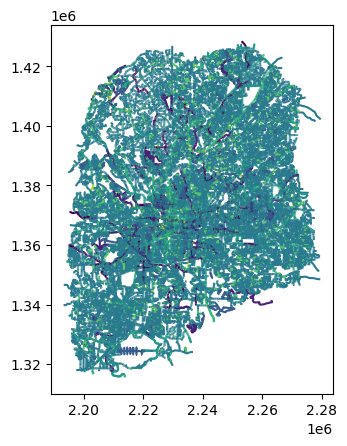

In [56]:
#todo automate the plot generation for when qgis isn't available
impedance_change.plot('imp_prop')

In [ ]:
impedance_change.to_file(config['calibration_fp']/"network_impedance_change.gpkg")

In [41]:
impedance_change['imp_prop'].describe()

count    76912.000000
mean         0.142017
std          0.138077
min         -0.272000
25%          0.126000
50%          0.126000
75%          0.126000
max          0.703000
Name: imp_prop, dtype: float64

In [55]:
sorted(impedance_change['imp_prop'].unique())

[-0.272,
 -0.184,
 -0.146,
 -0.02,
 0.0,
 0.053,
 0.126,
 0.141,
 0.179,
 0.252,
 0.305,
 0.325,
 0.378,
 0.451,
 0.577,
 0.703]

In [52]:
(impedance_change['imp_prop']==0).any()

True

In [42]:
impedance_change.imp_prop.round(3).value_counts()

 0.126    47699
 0.000     8637
 0.252     7885
 0.378     3855
 0.451     3277
-0.184     1799
-0.272     1561
 0.325     1165
 0.577      348
 0.703      240
-0.146      203
 0.141      174
 0.053       33
-0.020       26
 0.179        9
 0.305        1
Name: imp_prop, dtype: int64

## Train results

In [43]:
# #link_impedance_col = "adj_travel_time_min"
# base_impedance_col = "travel_time_min"
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

# #update impedances
# #betas = #past_betas[np.array(past_vals).argmin()]#x.x
# print(betas)
# stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
#                           stochastic_optimization.link_impedance_function,
#                           base_impedance_col,
#                           stochastic_optimization.turn_impedance_function,
#                           links,turns,turn_G)

# #find shortest path
# train_results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in train_ods}

# #calulate objective function
# loss_train = loss_function(train_set,train_results_dict,**loss_function_kwargs)
# loss_train[:,1].mean()

## Test Results

In [44]:
# #link_impedance_col = "adj_travel_time_min"
# base_impedance_col = "travel_time_min"
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

# #update impedances
# #betas = #past_betas[np.array(past_vals).argmin()]#x.x
# print(betas)
# stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
#                           stochastic_optimization.link_impedance_function,
#                           base_impedance_col,
#                           stochastic_optimization.turn_impedance_function,
#                           links,turns,turn_G)

# #find shortest path
# test_results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}

# #calulate objective function
# loss_test = loss_function(test_set,test_results_dict,**loss_function_kwargs)
# loss_test[:,1].mean()


In [45]:
# test0 = pd.DataFrame(loss_shortest_test,columns=['tripid','shortest'])
# test1 = pd.DataFrame(loss_test,columns=['tripid','impedance'])
# testing = pd.concat([test0,test1])

# train0 = pd.DataFrame(loss_shortest_train,columns=['tripid','shortest'])
# train1 = pd.DataFrame(loss_train,columns=['tripid','impedance'])
# training = pd.concat([train0,train1])

In [46]:
# #make dataframe and export results
# testing = pd.DataFrame({'tripid':list(test_set.keys()),'shortest':loss_shortest_test[:,1],'impedance':loss_test})
# testing.to_csv(config['calibration_fp']/'testing_results.csv',index=False)
# training = pd.DataFrame({'tripid':list(train_set.keys()),'shortest':loss_shortest_train[:,1],'impedance':loss_train})
# training.to_csv(config['calibration_fp']/'training_results.csv',index=False)

In [47]:
full = pd.DataFrame({'tripid':list(full_set.keys()),'shortest':loss_shortest_full[:,1],'impedance':loss_full[:,1]})
full.to_csv(config['calibration_fp']/'training_results.csv',index=False)

# Plot distribution of overlap values

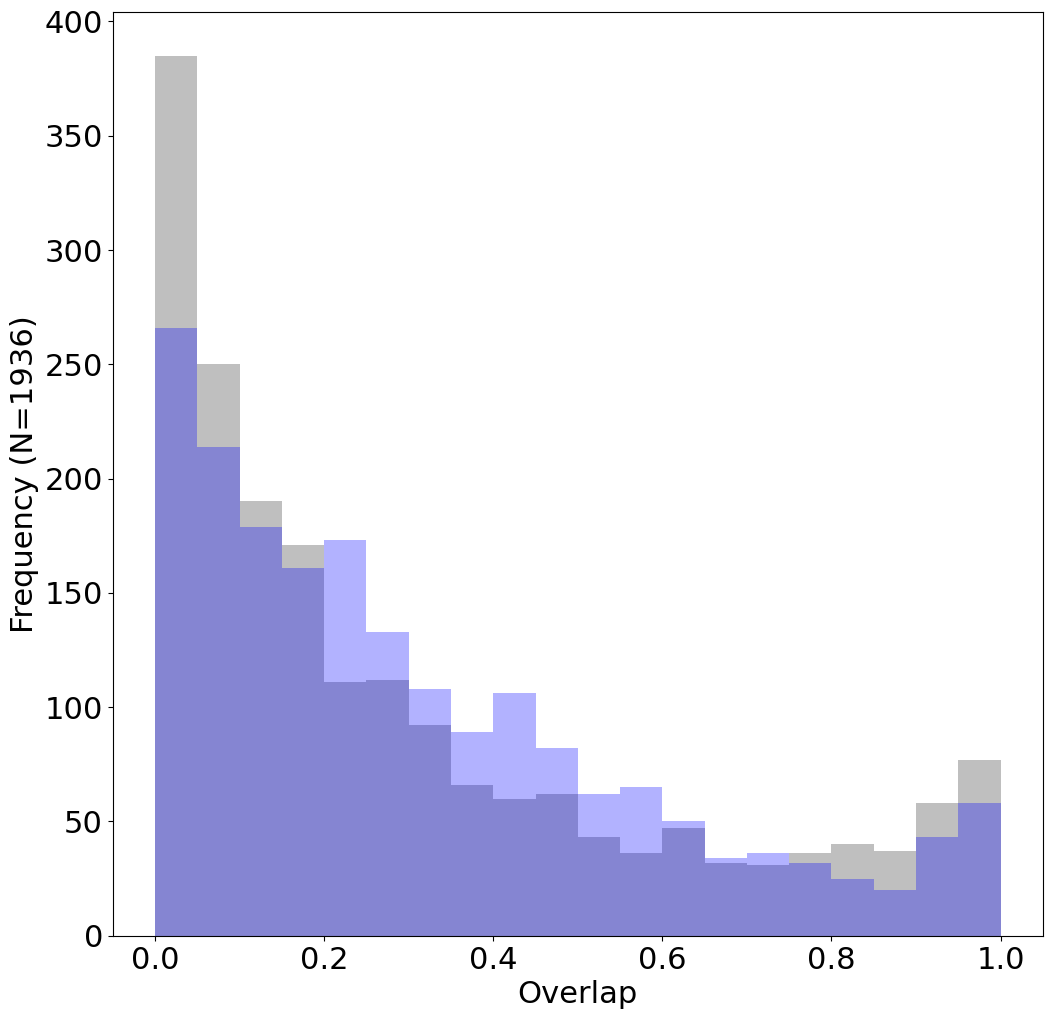

In [48]:
import pandas as pd
#loss_data = pd.DataFrame({'loss_shortest_full':loss_shortest_full,'loss_full':loss_full})

import matplotlib.pyplot as plt
# Create the histogram
#ax = loss_full_df.plot.hist(stacked=True, bins=20, figsize=(12, 12), color=['grey', 'lightgrey'])

# Create the histogram
plt.figure(figsize=(12, 12))
plt.hist(full['shortest'], bins=20, alpha=0.5, label='Shortest Path Overlap', color='grey')
plt.hist(full['impedance'], bins=20, alpha=0.3, label='Calibrated Overlap', color='blue')

# Adding labels, title, and legend with font size adjustments
plt.xlabel('Overlap', fontsize=22)
plt.ylabel(f'Frequency (N={full.shape[0]})', fontsize=22)
#plt.title('Histogram of Training Losses', fontsize=16)
#plt.legend(title='Tra Overlap', fontsize=22, title_fontsize=22)

# Adjusting the font size of the tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Show the plot
plt.show()

In [ ]:
# import pandas as pd
# loss_data = pd.DataFrame({'loss_shortest_train':loss_shortest_train,'loss_train':loss_train})

# import matplotlib.pyplot as plt
# # Create the histogram
# #ax = loss_train_df.plot.hist(stacked=True, bins=20, figsize=(12, 12), color=['grey', 'lightgrey'])

# # Create the histogram
# plt.figure(figsize=(12, 12))
# plt.hist(loss_data['loss_shortest_train'], bins=20, alpha=0.5, label='Shortest Path Overlap', color='grey')
# plt.hist(loss_data['loss_train'], bins=20, alpha=0.3, label='Calibrated Overlap', color='blue')

# # Adding labels, title, and legend with font size adjustments
# plt.xlabel('Overlap', fontsize=22)
# plt.ylabel('Frequency', fontsize=22)
# #plt.title('Histogram of Training Losses', fontsize=16)
# plt.legend(title='Training Overlap', fontsize=22, title_fontsize=22)

# # Adjusting the font size of the tick labels
# plt.xticks(fontsize=22)
# plt.yticks(fontsize=22)

# # Show the plot
# plt.show()

In [ ]:
# loss_data = pd.DataFrame({'loss_shortest_test':loss_shortest_test,'loss_test':loss_test})

# import matplotlib.pyplot as plt
# # Create the histogram
# #ax = loss_train_df.plot.hist(stacked=True, bins=20, figsize=(12, 12), color=['grey', 'lightgrey'])

# # Create the histogram
# plt.figure(figsize=(12, 12))
# plt.hist(loss_data['loss_shortest_test'], bins=20, alpha=0.5, label='Shortest Path Overlap', color='grey')
# plt.hist(loss_data['loss_test'], bins=20, alpha=0.3, label='Calibrated Overlap', color='blue')

# # Adding labels, title, and legend with font size adjustments
# plt.xlabel('Overlap', fontsize=22)
# plt.ylabel('Frequency', fontsize=22)
# #plt.title('Histogram of Training Losses', fontsize=16)
# plt.legend(title='Testing Overlap', fontsize=22, title_fontsize=22)

# # Adjusting the font size of the tick labels
# plt.xticks(fontsize=22)
# plt.yticks(fontsize=22)

# # Show the plot
# plt.show()

# Add modeled geometry to results dict for visualization


In [ ]:
#add a new modeled edges field so that we can calculate the modeled edges entry
for tripid, item in full_set.items():
    od = (item['origin_node'],item['destination_node'])
    modeled_edges = full_results_dict.get(od,0).get('edge_list',0)
    if isinstance(modeled_edges,int):
        print(modeled_edges)
    #turn to dataframe
    modeled_edges = pd.DataFrame(modeled_edges,columns=['linkid','reverse_link'])
    full_set[tripid].update({'modeled_edges':modeled_edges})

In [ ]:
# #add a new modeled edges field so that we can calculate the modeled edges entry
# for tripid, item in test_set.items():
#     od = (item['origin_node'],item['destination_node'])
#     modeled_edges = test_results_dict.get(od,0).get('edge_list',0)
#     if isinstance(modeled_edges,int):
#         print(modeled_edges)
#     #turn to dataframe
#     modeled_edges = pd.DataFrame(modeled_edges,columns=['linkid','reverse_link'])
#     test_set[tripid].update({'modeled_edges':modeled_edges})

In [ ]:
# #add a new modeled edges field so that we can calculate the modeled edges entry
# for tripid, item in test_set.items():
#     od = (item['origin_node'],item['destination_node'])
#     modeled_edges = test_results_dict.get(od,0).get('edge_list',0)
#     if isinstance(modeled_edges,int):
#         print(modeled_edges)
#     #turn to dataframe
#     modeled_edges = pd.DataFrame(modeled_edges,columns=['linkid','reverse_link'])
#     test_set[tripid].update({'modeled_edges':modeled_edges})

In [ ]:
#combine the test and train set dictionaries
modeled_results = {}
# modeled_results.update(train_set)
# modeled_results.update(test_set)
modeled_results.update(full_set)

In [ ]:
with (config['calibration_fp']/"full_modeled_results.pkl").open('wb') as fh:
    pickle.dump(modeled_results,fh)

## Add Route Attributes

In [ ]:
import summarize_route

In [ ]:
cols_to_summarize = {
    'facility_fwd': "category",
    'AADT': ("threshold",[10000]),
    'truck_pct': ("threshold",[5]),
    'here_speed': "category",
    'lanes': "category",
    'mixed_traffic_no_facil': "boolean",
    'mixed_traffic_w_facil': "boolean"
}

In [ ]:
links.set_index(['linkid','reverse_link'],inplace=True)
turns.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link'],inplace=True)

In [ ]:
links.columns

In [ ]:
# #unit conversions
links['length_mi'] = (links['length_ft'] / 5280).round(2)
links['ascent_ft'] = (links['ascent_m'] * 3.28084).round(0)
#links.drop(columns=['length_ft','ascent_m'],inplace=True)

In [ ]:
test_summary = [summarize_route.route_attributes(key,item,'modeled_edges',cols_to_summarize,links,turns) for key, item in test_set.items()]
test_summary = summarize_route.procees_summary_results(test_summary,config['projected_crs_epsg'])
test_summary.drop(columns=['tripid','geometry']).describe()

In [ ]:
train_summary = [summarize_route.route_attributes(key,item,'modeled_edges',cols_to_summarize,links,turns) for key, item in train_set.items()]
train_summary = summarize_route.procees_summary_results(train_summary,config['projected_crs_epsg'])
train_summary.drop(columns=['tripid','geometry']).describe()

## Combine and export route attributes

In [ ]:
summary = pd.concat([test_summary,train_summary],ignore_index=True)
summary.to_file(config['calibration_fp']/"route_attributes.gpkg",layer='modeled')

In [ ]:
summary.columns

# Regression Trees

In [ ]:
from sklearn import tree

testing = pd.read_csv(config['calibration_fp']/'testing_results.csv')
training = pd.read_csv(config['calibration_fp']/'training_results.csv')

#assume that keys are in the right order?
loss_df = pd.concat([testing,training],ignore_index=True)

In [ ]:
#import trip and user characteristics
trips_df = pd.read_pickle(cycleatl_fp/"trips_3.pkl")
users_df = pd.read_pickle(cycleatl_fp/"users_1.pkl")
trips_df.reset_index(drop=True,inplace=True)

In [ ]:
#import route attributes
matched_summary = gpd.read_file(config['calibration_fp']/"route_attributes.gpkg",layer="matched")
shortest_summary = gpd.read_file(config['calibration_fp']/"route_attributes.gpkg",layer="shortest")

In [ ]:
#consolidate trip types
trips_df.loc[trips_df['trip_type']=='other','trip_type'] = 'Other'
trips_df.loc[trips_df['trip_type']=='Work-related','trip_type'] = 'Work-Related'
trips_df['trip_type'].value_counts()

In [ ]:
#replace userid with just the first one
def take_first(x):
    if isinstance(x,list):
        return x[0]
    return x
users_df['userid'] = users_df['userid'].apply(take_first)

In [ ]:
#combine data
merged = pd.merge(loss_df,trips_df,on='tripid')
merged = pd.merge(merged.drop(columns=['userid']),users_df,left_on='remapped_userid',right_on='userid')
merged = pd.merge(merged, summary, on='tripid')
merged.columns

## Tree #1
- First tree is on the non-null variables
- The dist. between shortest and impedance were similar and so are the trees
- Shorter trips better explained by impedance/shortest path which makes sense
    - Use this to split longer trips? and retrain?
- Shopping is the only significant trip type variable
- Speed above 9 mph is usually better explained by impedance

In [ ]:
merged.columns

In [ ]:
nonulls = ['trip_type','length_mi','avg_speed_mph','(0,4]_prop', '(4,8]_prop',
       '(8,inf]_prop', 'AADT_10000_prop', 'facility_fwd_bike lane_prop',
       'facility_fwd_cycletrack_prop', 'facility_fwd_multi use path_prop',
       'facility_fwd_sharrow_prop', 'here_speed_1_prop', 'here_speed_2_prop',
       'here_speed_3_prop', 'here_speed_4_prop', 'lanes_1_prop',
       'lanes_2_prop', 'lanes_3_prop', 'left', 'right', 'signalized',
       'straight', 'truck_pct_5_prop', 'uturn']
nonulls_tree_df = merged[nonulls]

In [ ]:
from sklearn.tree import plot_tree

#convert nominal categorical to numeric
one_hot_data = pd.get_dummies(nonulls_tree_df,drop_first=True)
one_hot_data.columns

In [ ]:
X, y = one_hot_data.values, merged['impedance'].values
clf = tree.DecisionTreeRegressor(max_depth=3,min_samples_split=50)
clf = clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
plot_tree(clf, feature_names=one_hot_data.columns, filled=True, ax=ax)
plt.show()

In [ ]:
X, y = one_hot_data.values, merged['impedance'].values
clf = tree.DecisionTreeRegressor(max_depth=5)
clf = clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
plot_tree(clf, feature_names=one_hot_data.columns, filled=True, ax=ax)
plt.show()

In [ ]:
# how to compare predicted values vs actual?
SS_res = ((y - clf.predict(X))**2).sum()
SS_tot = ((y - y.mean())**2).sum()
R2 = 1 - (SS_res/SS_tot)
R2

## Tree #2
This one takes the previous variables and adds the user characterstics. Sample size is smaller due to null values

- Looks like trip distance is still the dominant one here, really think i should start there
- When removing trip distance and avg speed, trip type and age 55+ are the best

**NOTE:** just noticed that age should not be dummies, need to fix that and try again

In [ ]:
import json
user_data_definitions = json.load((Path.home()/'Documents/GitHub/cycleatlanta/user_data_definition.json').open('rb'))

#add the 55+ column
user_data_definitions['age']['6'] = '55+'

In [ ]:
#income has too many nulls
tree_cols = ['age','gender','rider_history','rider_type'] + nonulls #,'total_distance_ft','avg_speed_mph','count']#,'count']#[,'cycling_freq'
tree_df = merged[tree_cols]

#use to detect null values
isnull = ((tree_df == -1) | (tree_df == 'NULL'))

#TODO do cross-sectionals to see which combination results in the most retained entries

In [ ]:
#remove rows with null values
tree_df = tree_df[(isnull==False).all(axis=1)]

loss_vals = merged.loc[tree_df.index]

In [ ]:
get_factor = ['age','rider_history','rider_type']
# just fyi
# select_max_cols = ['age','income','cycling_freq']
# #select the min for these (i.e. strong and fearless over interested but...)
# select_min_cols = ['rider_type','rider_history']

for col in get_factor:
    ivd = {v:k for k, v in user_data_definitions[col].items()}
    tree_df[col] = tree_df[col].map(ivd)

In [ ]:
tree_df

In [ ]:
#this is where i left off
#convert nominal categorical to numeric
dummy_cols = ['gender','trip_type']
one_hot_data = pd.get_dummies(tree_df[dummy_cols],drop_first=True)
comb = pd.concat([tree_df.drop(columns=dummy_cols),one_hot_data],ignore_index=False,axis=1)
comb

In [ ]:
X, y = comb.values, loss_vals['impedance'].values
clf = tree.DecisionTreeRegressor(max_depth=3,min_samples_split=50)
clf = clf.fit(X, y)
#tree.plot_tree(clf,feature_names=one_hot_data.columns)
# Visualize the tree with higher resolution
plt.figure(figsize=(20, 10), dpi=300)
from sklearn.tree import plot_tree
plot_tree(clf, feature_names=comb.columns, filled=True)
plt.show()

In [ ]:
# how to compare predicted values vs actual?
SS_res = ((y - clf.predict(X))**2).sum()
SS_tot = ((y - y.mean())**2).sum()
R2 = 1 - (SS_res/SS_tot)
R2

What we actually want to know, is what variables help increase the overlap? So wouldn't that be more of an application for linear regression?

clf

Since the squared error is already pretty high and our histogram tells us, most of these trips are not currently well predicted with the current impedances. The idea behind using regression trees here is can we figure out if attributes help exmplain the bad overlap?

Or we could just try knocking off 

In [ ]:
#correlation matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = one_hot_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

one_hot_data.corr()

# Distribution of Loss Function

# Export to get route attributes

# Using BRouter Results
To compare across we'll use Frechet distance. Will need to use next time.

In [ ]:
with (config['calibration_fp']/'brouter_links.txt').open('r') as file:
    my_list = file.readlines()
    # Remove any extra whitespace or newline characters
    my_list = [line.strip() for line in my_list]
len(my_list)

In [ ]:
geojsons = list((config['calibration_fp']/'GeoJSON_Out').glob('*.geojson'))

In [ ]:
both_ods = list(set.union(set(train_ods),set(test_ods)))
len(both_ods)

In [ ]:
test_ods

In [ ]:
len(geojsons)

In [ ]:
#use the results dict combined with the geo dict one
results_dict[(68166811, 8789832117)]
#

In [ ]:
geojson_geos = []
for geojson in geojsons:
    geojson_geo = gpd.read_file(geojson).to_crs(config['projected_crs_epsg'])
    geojson_geo = np.array(geojson_geo.geometry.item().coords)
    # geojson_geo = [(x, y) for x, y, z in geojson_geo.coords]
    # geojson_geo = LineString(geojson_geo)
    geojson_geos.append(geojson_geo)

In [ ]:
frechet_distance = similaritymeasures.frechet_dist(chosen_coords,modeled_coords)

In [ ]:
#import and compare frechet distance across them with geodict?
list(geojson_geo.coords)

# Visualize

In [ ]:
matched_gdf = gpd.read_file(config['calibration_fp']/'route_attributes.gpkg',layer="matched")
modeled_gdf = gpd.read_file(config['calibration_fp']/'route_attributes.gpkg',layer="modeled")

In [ ]:
matched_gdf